__Татур А.А.__
__v.01__
__23/12/2022__

__Задание__

1. Выполнить Стэкинг, Бэгин и Бустинг. 
2. При реализации алгоритмов не использовать готовые решения. 
3. За сравнение взять CatBoostClassifier как базовая метрика качества. 
4. Сравнить результат с реализацией своих ансамблей. 
5. Для однозначности и интерпретируемости результатов использовать приложенный набор данных. 
6. При реализации бустинга - просто сокращайте набор данных на котором модель отработала хорошо (правильно предсказанные данные). Попробуйте просто удалять % от данных на которых алгоритм работал хорошо. Например сделать 20 итераций удаляя на каждом этапе по 5% от верно предсказанных.

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from catboost import CatBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import validation_curve, learning_curve

import warnings
warnings.filterwarnings('ignore')

In [209]:
df=pd.read_csv('winequality-white.csv',
              sep=';')

In [210]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [211]:
df.loc[df.quality<=5, 'quality']=0
df.loc[df.quality>=6, 'quality']=1

In [212]:
df.quality.value_counts()

1    3258
0    1640
Name: quality, dtype: int64

In [213]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [214]:
df.duplicated().sum()

937

In [215]:
df.drop(df.loc[df.duplicated()].index, axis=0, inplace=True)

In [216]:
X=df.drop('quality', axis=1)
y=df.quality

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [218]:
results = {}

## I. Делаем референтные значения при помощи - Catboost classifier

In [219]:
catb_pipeline = Pipeline([('scale', StandardScaler()),
                          ('catb', CatBoostClassifier(logging_level='Silent'))    
                        ])
catb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('catb',
                 <catboost.core.CatBoostClassifier object at 0x00000189E2438C70>)])

In [220]:
y_pred=catb_pipeline.predict(X_test)

In [221]:
roc_auc_score(y_test, y_pred)

0.7262017710309931

In [222]:
results ['CatBoost'] = roc_auc_score(y_test, y_pred)

## II. Ансамбли

#### 01. Voting Classifier из коробки

In [223]:
from sklearn.ensemble import VotingClassifier

dtc = DecisionTreeClassifier()
svc = SVC (probability=True)
knn = KNeighborsClassifier()


voting_clf = VotingClassifier(
    estimators=[('svc', svc), ('dtc', dtc), ('knn', knn)],
    voting='hard')

voting_pipe = Pipeline([('scale', StandardScaler()),
                          ('voting', voting_clf)    
                        ])

In [224]:
voting_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('voting',
                 VotingClassifier(estimators=[('svc', SVC(probability=True)),
                                              ('dtc', DecisionTreeClassifier()),
                                              ('knn',
                                               KNeighborsClassifier())]))])

In [225]:
y_pred=voting_pipe.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7216589861751151

In [226]:
results ['Voting (BOX)'] = roc_auc_score(y_test, y_pred)

#### 02. Voting Classifier - собственная реализация. 
#### HARD 

In [227]:
#Обучаем DecisionTreeClassifier и делаем предикт.
dtc = DecisionTreeClassifier()
dtc.fit (StandardScaler().fit_transform(X_train), y_train)
predict_dtc = dtc.predict (StandardScaler().fit_transform(X_test))

#Обучаем SVC и делаем предикт.
svc = SVC(probability=True)
svc.fit (StandardScaler().fit_transform(X_train), y_train)
predict_svc = svc.predict (StandardScaler().fit_transform(X_test))

#Обучаем KNeighborsClassifier и делаем предикт.
knn = KNeighborsClassifier()
knn.fit (StandardScaler().fit_transform(X_train), y_train)
predict_knn = knn.predict (StandardScaler().fit_transform(X_test))

In [228]:
hard = predict_dtc + predict_svc + predict_knn

In [229]:
roc_auc_score(y_test, (hard>1).astype(int))

0.706447094967019

In [230]:
results ['Voting (OWN_HARD)'] = roc_auc_score(y_test, (hard>1).astype(int))

#### SOFT

In [231]:
#Обучаем DecisionTreeClassifier и делаем предикт.
dtc = DecisionTreeClassifier()
dtc.fit (StandardScaler().fit_transform(X_train), y_train)
predict_dtc = dtc.predict_proba (StandardScaler().fit_transform(X_test))

#Обучаем LogisticRegression и делаем предикт.
svc = SVC(probability=True)
svc.fit (StandardScaler().fit_transform(X_train), y_train)
predict_svc = svc.predict_proba (StandardScaler().fit_transform(X_test))

#Обучаем KNeighborsClassifier и делаем предикт.
knn = KNeighborsClassifier()
knn.fit (StandardScaler().fit_transform(X_train), y_train)
predict_knn = knn.predict_proba (StandardScaler().fit_transform(X_test))

In [232]:
soft = predict_dtc + predict_svc + predict_knn

In [233]:
roc_auc_score(y_test, np.argmax(soft, axis=1))

0.6921162013192373

In [234]:
results ['Voting (OWN_SOFT)'] = roc_auc_score(y_test, np.argmax(soft, axis=1))

#### 03. Stacking classifier - из коробки

In [235]:
from sklearn.ensemble import StackingClassifier

dtc = DecisionTreeClassifier()
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()

stacking_clf = StackingClassifier(
    estimators=[('dtc', dtc), ('lr', lr), ('knn', knn)],
    final_estimator=lr, 
    n_jobs=-1, 
    verbose=1)

stacking_pipe = Pipeline([('scale', StandardScaler()),
                          ('stacking', stacking_clf)    
                        ])

In [236]:
stacking_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('stacking',
                 StackingClassifier(estimators=[('dtc',
                                                 DecisionTreeClassifier()),
                                                ('lr',
                                                 LogisticRegression(max_iter=1000)),
                                                ('knn',
                                                 KNeighborsClassifier())],
                                    final_estimator=LogisticRegression(max_iter=1000),
                                    n_jobs=-1, verbose=1))])

In [237]:
y_pred=stacking_pipe.predict(X_test)

In [238]:
roc_auc_score(y_test, y_pred)

0.7228856058552453

In [239]:
results ['Stacking (BOX)'] = roc_auc_score(y_test, y_pred)

#### 04. Stacking classifier - собственная реализация

In [240]:
dtc = DecisionTreeClassifier()
dtc.fit (StandardScaler().fit_transform(X_train), y_train)
predict_dtc = dtc.predict (StandardScaler().fit_transform(X_test))

lr = LogisticRegression(max_iter=1000)
lr.fit (StandardScaler().fit_transform(X_train), y_train)
predict_lr = lr.predict (StandardScaler().fit_transform(X_test))

knn = KNeighborsClassifier()
knn.fit (StandardScaler().fit_transform(X_train), y_train)
predict_knn = knn.predict (StandardScaler().fit_transform(X_test))

In [241]:
predict_stack = np.stack ((predict_dtc, predict_lr, predict_knn), axis = 1)
lr. fit (predict_stack, y_test)
y_pred = lr.predict(predict_stack)
roc_auc_score(y_test, y_pred)

0.7080487033523087

In [242]:
results ['Stacking (OWN)'] = roc_auc_score(y_test, y_pred)

#### 05. Bagging classifier - из коробки

In [243]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(lr, n_estimators=1000,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bagging_pipe = Pipeline([('scale', StandardScaler()),
                          ('bagging', bagging_clf)    
                        ])

In [244]:
bagging_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('bagging',
                 BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000),
                                   max_samples=100, n_estimators=1000,
                                   n_jobs=-1, random_state=42))])

In [245]:
y_pred=bagging_pipe.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6783093882714376

In [246]:
results ['Bagging (BOX)'] = roc_auc_score(y_test, y_pred)

#### 06. Bagging classifier - собственная реализация

In [306]:
class SimpleBagging:
    '''
    model - ML model
    n_iter - total number of iterations
    sample_size - (0-1] - percent of data set, that takes a part in fitting process
    '''
    def __init__ (self, model, n_iter, sample_size):
        self.model = model
        self.n_iter = n_iter
        self.sample_size = sample_size
        self.models = [] ### Список с обученными моделями
        self.score = []  ### Список с результатами предсказаний
    
    def fit (self, X_train, y_train):
        
        for i in range (self.n_iter):
            
            self.model ()        
            
            rng = np.random.default_rng()
            
            rnd = rng.integers(0, len(X_train), 
                               size=int(self.sample_size*len(X_train)), 
                               dtype=np.int64)
    
            X_train_short = X_train.iloc[rnd]
            y_train_short = y_train.iloc[rnd]

            self.models.append (self.model().fit (X_train_short, y_train_short))
    
    ### В качестве предикта идет HARD голосование. За наличие признака считается если получена большая часть голосов.
    def predict (self, X_test):
        for model in self.models:
            self.score.append (model.predict (X_test))
        hard = np.sum (np.array (self.score).T, axis=1)
        return (hard>(int(self.n_iter/2)+1)).astype(int)

In [313]:
b = SimpleBagging (DecisionTreeClassifier, 100, 0.4)

In [314]:
b.fit (X_train, y_train)

In [315]:
bagging_predict = roc_auc_score (y_test, b.predict(X_test))
bagging_predict

0.7332271618324749

In [316]:
results ['Bagging (OWN)'] = bagging_predict

##### 07. Boosting classifier - из коробки

In [252]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier (n_estimators=100, random_state=0)

clf.fit (X_train, y_train)
roc_auc_score(y_test, clf.predict(X_test))

0.6927532303243878

In [253]:
results ['Boosting (BOX)'] = roc_auc_score(y_test, clf.predict(X_test))

##### 08. Boosting classifier - собственная реализация

In [322]:
class SimpleBoost ():
    
    '''
    SimpleBoost - is a class, demonstrates how boosting works. It has 3 parametrs:
    1. model - is a ML model
    2. n_drop - [0-1] is a pecent of correctly predicted y_values to remove on each itearation
    3. n_iter - [0-inf) is a number of iteration
    '''
    
    def __init__ (self, model, n_drop=0.05, n_iter=5):
        self.model = model
        self.n_drop=n_drop
        self.n_iter=n_iter
    
    def fit (self, X_train, y_train):
        
        for x in range (self.n_iter):
            
            model = self.model.fit (X_train, y_train)
            y_pred = model.predict(X_train)
            
            ind_to_drop = int(sum(y_pred==y_train)*self.n_drop)
            
            X_train = X_train.drop(X_train.loc[y_pred==y_train].index[:ind_to_drop], 
                                   axis=0)
            y_train = y_train.drop(y_train.loc[y_pred==y_train].index[:ind_to_drop], 
                                   axis=0)
        
        self.model = model
        print(model)
        
    def predict (self, X_test):
        return (self.model.predict (X_test))       

In [341]:
a = SimpleBoost (RandomForestClassifier(), 
                 n_drop=0.05, 
                 n_iter=15)
a.fit (X_train, y_train)

RandomForestClassifier()


In [342]:
roc_auc_score(y_test, a.predict(X_test))

0.7320841239721696

In [344]:
results ['Boosting (OWN)'] = roc_auc_score(y_test, a.predict(X_test))

#### Результаты

Text(0.5, 1.0, 'Results of different ML models')

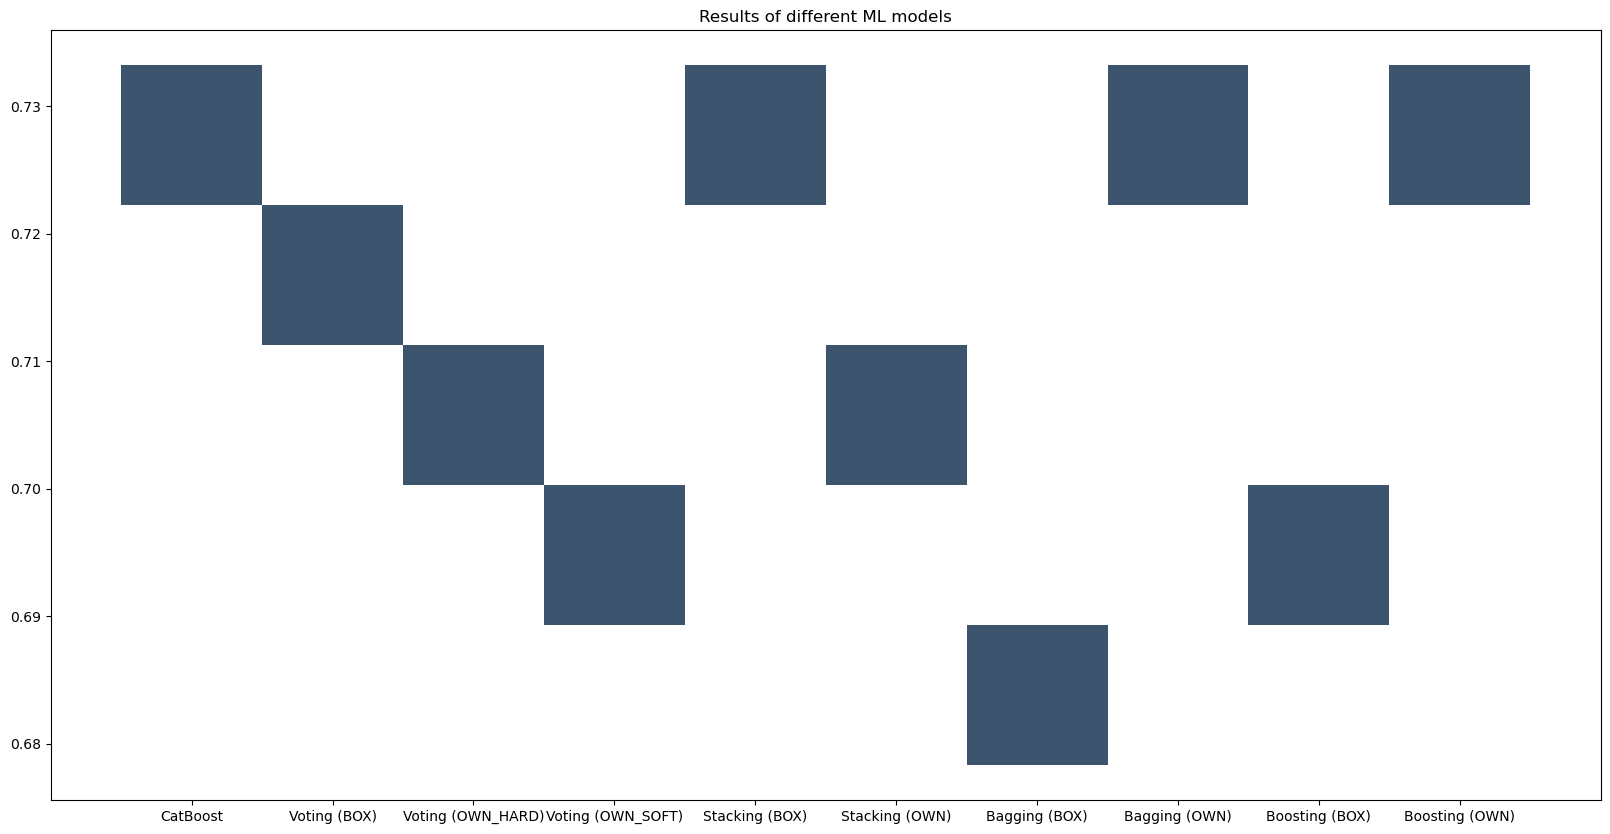

In [395]:
plt.figure (figsize=(20,10))
sns.histplot (data=results,
             x=results.keys(),
             y=results.values());
plt.title ('Results of different ML models')

In [396]:
results

{'CatBoost': 0.7262017710309931,
 'Voting (BOX)': 0.7216589861751151,
 'Voting (OWN_HARD)': 0.706447094967019,
 'Voting (OWN_SOFT)': 0.6921162013192373,
 'Stacking (BOX)': 0.7228856058552453,
 'Stacking (OWN)': 0.7080487033523087,
 'Bagging (BOX)': 0.6783093882714376,
 'Bagging (OWN)': 0.7332271618324749,
 'Boosting (BOX)': 0.6927532303243878,
 'Boosting (OWN)': 0.7320841239721696}

### Наилучшие результаты продемонстрировали CatBoost - 0.7262, Stacking (BOX) - 0.7228, Bagging (OWN) - 0.7332, Boosting (OWN) - 0.732